In [1]:
import random
from random import randrange

from ase.io import write
from ase.data import atomic_numbers
from ase.ga.data import PrepareDB
from ase.visualize import view
from ase.calculators.siesta import Siesta
from ase.units import Ry

import numpy as np
import os

from pyxtal import pyxtal

import seaborn as sns
import pandas as pd

## Inputs

In [2]:
name = 'MoS2'                                    # Name of the structure 
file_name = f'DateBase_{name}_rulette.txt'       # File name
species = ['Mo', 'S']                            # Chemical species of the structure
quantity = [1, 2]                                # Quantity of chemical species in elemental cell
n_atoms = sum(quantity)                          # Number of atoms in cell
thickness = 5.0                                  # Thickness of the structure

pop_size = 6                                     # Number of structures in population
prob= 0.5                                        # Percentage of best indyviduals passing to the next generation
n_gen = 4                                        # Number of generations

In [3]:
def dist(v1, v2): 
    """Returns distance two atoms

    Args:
        v1 (list[float]): First vector 
        v2 (list[float]): Second vector

    Returns:
        float: Distance of two vectors
    """
    
    d = np.sqrt((v1[0] - v2[0]) * (v1[0] - v2[0]) + (v1[1] - v2[1]) * (v1[1] - v2[1]) + (v1[2] - v2[2]) * (v1[2] - v2[2]))
    return d

In [4]:
def check_dist(number_atoms, positions, d_min, d_max):
    """Restrict of the distance between atoms 

    Args:
        number_atoms (int): Number of atoms
        positions (array[float]): Atom positions   
        d_min (float): Minimum allowable distance
        d_max (float): Maximum allowable distance

    Returns:
        bool: Returns True if conditions are fulfilled anyway False
    """

    flag = True
    for i in range(number_atoms):
        for j in range(number_atoms):
            if i != j:
                distance = dist(positions[i], positions[j])
                if (distance < d_min) or (distance > d_max):
                    flag = False
    return flag

# Structure Initialisation 

In [5]:
def init_atoms():  
    """Initialization of the structure

    Returns:
        ase.Atoms: Structure
    """

    atoms_out = None

    number_attempts = 200 # no of attempts
    d_min = 1.0 # min distance
    d_max = 2.5 # max distance
    
    for i in range(number_attempts):
        group_id = randrange(80) + 1 
        my_crystal = pyxtal()
        
        try:
            my_crystal.from_random(2, group_id, species, quantity, thickness=thickness)
        except RuntimeError:
            continue
        
        atoms = my_crystal.to_ase()
        positions = atoms.get_positions()
        number_atoms = len(atoms.get_chemical_symbols()) 
        


        flag = check_dist(number_atoms, positions, d_min, d_max)
        
        if flag==True:
            atoms_out = atoms
            break
    return atoms_out

## Siesta calculator 
Siesta User's Guide: <https://departments.icmab.es/leem/SIESTA_MATERIAL/Docs/Manuals/siesta-4.1-b4.pdf> 

In [6]:
calc = Siesta(label=name,       
               xc='PBE',
               mesh_cutoff=200 * Ry,
               energy_shift=0.01 * Ry,
               basis_set='SZP',
               kpts=[12, 12, 1],
               pseudo_path='/home/czeski/Pobrane/siesta-4.1-b4/pseudo',
               fdf_arguments={'MaxSCFIterations': 500,   
                              'DM.Tolerance': 1.E-5,
                              'DM.NumberPulay': 6,                        
                              'DM.NumberBroyden': 0,
                              'DM.MixingWeight': 0.1000000000,             
                              'DM.OccupancyTolerance':0.1000000000E-11,         
                              'DM.NumberKick': 0,                        
                              'DM.KickMixingWeight': 0.5000000000,
                              'MD.NumCGsteps': 150,                        
                              'MD.TypeOfRun': 'CG',                       
                              'MD.VariableCell': 'F',                        
                              'WriteMullikenPop': 1,    
                              'WriteDenchar': True,      
                              'WriteKpoints': True,      
                              'WriteForces': True,      
                              'WriteDM': True,      
                              'WriteXML': True,      
                              'WriteEigenvalues': False, 
                              'WriteCoorStep': True,      
                              'WriteMDhistory': True,    
                              'WriteMDXmol': True,      
                              'WriteCoorXmol': True, 
                             },)

## Indyvidual

In [7]:
class Indyvidual:
    def __init__(self, structure,n_gen):
        """ Indyvidual constructor

        Args:
            structure (ase.Atoms) : Atom 
            n_gen (int) : Number of the generation
        """
        
        self.calc = calc                    
        self.init_structure = structure     
        self.energy = 0.0
        self.ngen = n_gen
        self.status = 'Random'
        
    def calc_energy(self):
        try:
            self.init_structure.calc = calc
            self.energy = self.init_structure.get_potential_energy()
        except:
            print("energy calculation failed")
            self.energy = +1000.
    def next_gen(self):
        self.ngen = self.ngen + 1
        
    def mutation(self):
        positions = self.init_structure.get_positions()
        new = [ n + (random.random()-0.5) for n in positions]    
        self.init_structure.set_positions(new)
        self.status = 'Mutated'
    
    def get_init_structure(self):
        return self.init_structure.copy()
    
    def get_energy(self):
        return self.energy
    
    def get_ngen(self):
        return self.ngen
    
    def get_position(self):
        return self.init_structure.get_positions()
    
    def get_status(self):
        """Returns where the individual came from.

        Returns:
            str: Origin of the individual
        """
        return self.status

    def set_status(self, status):
        self.status = status

    

    

In [8]:
def energy_sorting(pop):
    """Sorts arrays from the lowest energy to the highest.
       Prints all population

    Args:
        pop (array[ase.Atoms]): Populaion of indyviduals 

    Returns:
        array[ase.Atoms] : Sorted population of indyviduals
    """
    
    for i in range(len(pop)):
            pop[i].calc_energy()        
    sorted_pop = sorted(pop, key=lambda x: x.energy) 

    # Printing sorted energy
    for i in range(len(sorted_pop)):
        print(sorted_pop[i].get_energy())

    return sorted_pop
    

## Choice by Rulette 

In [9]:
def choice_by_rulette(pop):
    """ Choice the Indyvidual of the population to mutation

    Args:
        pop (array[Ase.Atoms]): [description]

    Returns:
        int: Number of indyvidual chosen to mutation
    """
    
    #Totaly population fitness
    population_sum = sum([individual.get_energy() for individual in pop])
    
    #Each individual probability
    individuals_prob = [individual.get_energy()/population_sum for individual in pop]
    
    n = np.arange(0,len(pop))#The best indyvidual in untouchable
    while True:
        chosen_num =  np.random.choice(n, p=individuals_prob)
        if chosen_num !=0:
            return chosen_num



# Crossover

In [10]:
def crossover(pop):
    """ Takes two random structures and swaps their random atom positions 

    Args:
        pop (list[ase.Atoms]): Population

    Returns:
        list[ase.Atoms]: Crossovered population
    """
    
    number_population = len(pop)

    while True:

        # Draw 2 indyviduals
        rand_ind1 = random.randint(0,number_population-1)
        rand_ind2 = random.randint(0,number_population-1)

        if rand_ind1 == rand_ind2:
            continue
        # Draw atom to swap
        rand_atom1 = random.randint(0,n_atoms-1)
        rand_atom2 = random.randint(0,n_atoms-1)

        
        # Swap atoms positions
        temp = pop[rand_ind1].get_init_structure()[rand_atom1].position
        pop[rand_ind1].get_init_structure()[rand_atom1].position = pop[rand_ind2].get_init_structure()[rand_atom2].position
        pop[rand_ind2].get_init_structure()[rand_atom2].position = temp

        # Set status of indyvidual as Crossovered
        pop[rand_ind1].set_status("Crossovered")
        pop[rand_ind2].set_status("Crossovered")

        return pop


## Starting population

In [11]:
number_indyviduals =int(prob*pop_size)         #Amount of individuals going to the next generation
arr = np.arange(number_indyviduals,pop_size)   #Array of iterations
best = []                                      #Array of best indyviduals
data = []                                      #Array for data base

f=open(file_name, "w")


#Preapering first population
pop = [] 
i=1
while (len(pop)<pop_size):
    pop.append(Indyvidual(init_atoms(), 1))
    i=i+1

pop = crossover(pop)

sorted_pop = energy_sorting(pop)
data.append(sorted_pop)                         #Collecting data
best.append(sorted_pop[0].get_energy())

/home/czeski/anaconda3/lib/python3.8/site-packages/pyxtal/msg.py:21: UserWarning: Error: the stoichiometry is incompatible with wyckoff choice
  warn(text)


-772.273565
-770.483283
-764.165261
-744.374331
-734.634289
-727.545078


## Next Generation - Choice by Roulette

In [12]:
for g in range(n_gen):

    # % of the best individuals go to the next generation
    new_pop = sorted_pop[0 : int(prob*pop_size)]         

    chosen = choice_by_rulette(new_pop)
    new_pop[chosen].mutation()
    new_pop[chosen].calc_energy()
    
    #Appending new random individuals
    while (len(new_pop)<(pop_size)):                   
        new_pop.append(Indyvidual(init_atoms(), g+2))
    

    #Crossover
    new_pop = crossover(new_pop)

    #Calculating energy of new individuals
    for i in arr:
        new_pop[i].calc_energy()                 

    #Sorting Population
    sorted_pop = sorted(new_pop, key=lambda x: x.energy)
    
    print("\nGeneration nr:",g + 1)
    print("Sorted Energies:")
    
    for i in range(len(sorted_pop)):
        print(sorted_pop[i].get_energy())
    best.append(sorted_pop[0].get_energy())
    
    data.append(sorted_pop)
    write(filename=f"BestStructGen{g+1}rulette{name}.in", images=sorted_pop[0].init_structure, format='espresso-in')
    





Generation nr: 1
Sorted Energies:
-772.273565
-769.981728
-764.165261
-760.984269
-733.796661
-725.788048

Generation nr: 2
Sorted Energies:
-774.661679
-772.273565
-771.712476
-769.981728
-769.4774
-766.389768
energy calculation failed

Generation nr: 3
Sorted Energies:
-776.584911
-774.661679
-772.274251
-771.712476
-721.005383
1000.0

Generation nr: 4
Sorted Energies:
-776.584911
-774.662022
-772.274251
-767.053632
-752.367605
-731.350912


## View Best Individual

In [13]:
from ase import Atoms
from ase_notebook import AseView, ViewConfig, get_example_atoms

config = ViewConfig()
ase_view = AseView(config)

ase_view = AseView(
    rotations="0x,0y,0z",
    atom_font_size=16,
    axes_length=30,
    canvas_size=(400, 400),
    zoom=1.2,
    show_bonds=True
)
ase_view.config.uc_dash_pattern=(.6,.4)
ase_view.add_miller_plane(
    1, 0, 0, color="green")
ase_view.config



ase_view.config.canvas_color_background = "white"
ase_view.config.canvas_background_opacity = 0
gui = ase_view.make_render(
    sorted_pop[0].get_init_structure() , center_in_uc=True)
gui

GridspecLayout(children=(Renderer(camera=PerspectiveCamera(fov=10.0, position=(0.0, 0.0, 50.960710057666496), …

## Creating Database 

In [14]:
ind = []
for i in range(len(data)):
    for j in range(pop_size):
        ind.append(data[i][j])    

In [15]:
d = {'indyvidual': ind}
df=pd.DataFrame(data = d)
df

def get_energyDF(x):
    return x.get_energy()

def get_ngenDF(x):
    return x.get_ngen()

def get_statusDF(x):
    return x.get_status()


df['energy'] = df['indyvidual'].apply(get_energyDF)
df['n_gen'] = df['indyvidual'].apply(get_ngenDF)
df['status'] = df['indyvidual'].apply(get_statusDF)

df = df.drop_duplicates(subset=['indyvidual'], keep='last')
df.sort_values('energy')


,indyvidual,energy,n_gen,status
24,<__main__.Indyvidual object at 0x7f93b6a410d0>,-776.584911,4,Crossovered
25,<__main__.Indyvidual object at 0x7f93b49e43a0>,-774.662022,3,Mutated
26,<__main__.Indyvidual object at 0x7f93b49e4160>,-772.274251,1,Crossovered
21,<__main__.Indyvidual object at 0x7f93b6ad71c0>,-771.712476,1,Mutated
15,<__main__.Indyvidual object at 0x7f94184f13a0>,-769.981728,1,Crossovered
16,<__main__.Indyvidual object at 0x7f9408c57e20>,-769.477400,3,Random
27,<__main__.Indyvidual object at 0x7f93b4a15ca0>,-767.053632,5,Crossovered
17,<__main__.Indyvidual object at 0x7f93b49e4c10>,-766.389768,3,Crossovered
9,<__main__.Indyvidual object at 0x7f93b6aff340>,-760.984269,2,Random
28,<__main__.Indyvidual object at 0x7f9408c57a30>,-752.367605,5,Random


#### Writting best structure espresso_in file 
#### Writting DataBase to csv

In [16]:
write(filename=f"TheBestStruct_{name}.in", images=sorted_pop[0].init_structure, format='espresso-in')
df.to_csv(f"DataBase_{name}.csv")

#### Creating best Indyviduals Plot

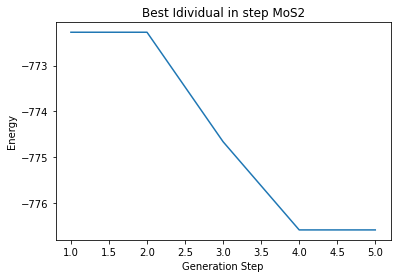

In [17]:
f = sns.lineplot(x=np.arange(1, n_gen+2), y=best)
f.set(xlabel='Generation Step', ylabel='Energy', title=f'Best Idividual in step {name}')
sns.axes_style()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})